In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.saving import register_keras_serializable

In [2]:
mnist = tfds.load(
    'mnist',
    split=['train[:80%]','train[80%:]', 'test'],
    as_supervised=True

)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.F7TFR5_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.F7TFR5_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
train_dataset, valid_dataset, test_dataset = mnist[0], mnist[1], mnist[2]

In [4]:
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    # The error is happening here because labels are not one-hot encoded. Let's encode them:
    label = tf.one_hot(label, depth=10) # One-hot encode the labels with depth 10 (for 10 MNIST classes)

    return image, label

batch_size = 32
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

train_dataset = train_dataset.map(preprocess_data)
valid_dataset = valid_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

In [5]:
train_dataset = train_dataset.shuffle(1000)
valid_dataset = valid_dataset.shuffle(1000)
test_dataset = test_dataset.shuffle(1000)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [6]:
def resize_images(image, label):
    image = tf.image.resize(image, [28,28])
    return image, label

train_dataset = train_dataset.map(resize_images)
valid_dataset = valid_dataset.map(resize_images)

(32, 28, 28, 1)


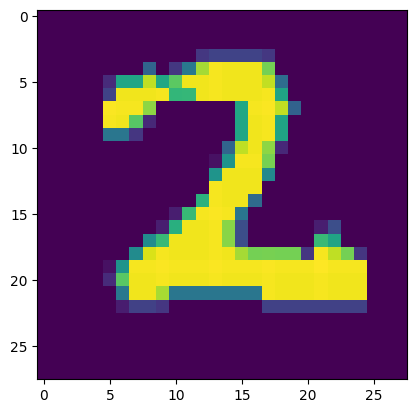

tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

In [7]:
for image,label in train_dataset.take(1):
  x = print(image.shape)
  y = label

import matplotlib.pyplot as plt
plt.imshow(image[0])
plt.show()
print(y)

In [8]:
for x, y in train_dataset.take(1):
    print(f"Input shape: {x.shape}")
    print(f"Label shape: {y.shape}")

Input shape: (32, 28, 28, 1)
Label shape: (32, 10)


In [9]:
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="CustomLayers")
class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self, branch1, branch2, branch3, branch4, activation='elu', **kwargs):
        super(InceptionBlock, self).__init__(**kwargs)
        self.branch1 = branch1
        self.branch2 = branch2
        self.branch3 = branch3
        self.branch4 = branch4
        self.activation = activation

    def build(self, input_shape):
        # Define layers for each branch
        self.branch1_conv = tf.keras.layers.Conv2D(self.branch1, (1, 1), activation=self.activation)
        self.branch2_conv1 = tf.keras.layers.Conv2D(self.branch2[0], (1, 1), activation=self.activation)
        self.branch2_conv2 = tf.keras.layers.Conv2D(self.branch2[1], (3, 3), padding='same', activation=self.activation)
        self.branch3_conv1 = tf.keras.layers.Conv2D(self.branch3[0], (1, 1), activation=self.activation)
        self.branch3_conv2 = tf.keras.layers.Conv2D(self.branch3[1], (5, 5), padding='same', activation=self.activation)
        self.branch4_pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')
        self.branch4_conv = tf.keras.layers.Conv2D(self.branch4[0], (1, 1), activation=self.activation)

        # Call super().build() to mark the layer as built
        super(InceptionBlock, self).build(input_shape)

    def call(self, inputs):
        # Apply each branch
        b1 = self.branch1_conv(inputs)
        b2 = self.branch2_conv1(inputs)
        b2 = self.branch2_conv2(b2)
        b3 = self.branch3_conv1(inputs)
        b3 = self.branch3_conv2(b3)
        b4 = self.branch4_pool(inputs)
        b4 = self.branch4_conv(b4)
        # Concatenate all branches
        return tf.concat([b1, b2, b3, b4], axis=-1)

    def get_config(self):
        config = super(InceptionBlock, self).get_config()
        config.update({
            'branch1': self.branch1,
            'branch2': self.branch2,
            'branch3': self.branch3,
            'branch4': self.branch4,
            'activation': self.activation
        })
        return config

In [ ]:
filters = [
    [64, [96, 128], [16, 32], [32]],
    [128, [128, 192], [32, 96], [64]],
    [192, [96, 208], [16, 48], [64]],
    [160, [112, 224], [24, 64], [64]],
    [128, [128, 256], [24, 64], [64]],
    [112, [144, 288], [32, 64], [64]]
]

inception_units = []

for i, unit in enumerate(filters):
    print(f"Creating InceptionBlock {i} with filters: {unit}")
    inception_units.append(InceptionBlock(unit[0], unit[1], unit[2], unit[3]))

print(f"Total InceptionBlocks created: {len(inception_units)}")

Creating InceptionBlock 0 with filters: [64, [96, 128], [16, 32], [32]]
Creating InceptionBlock 1 with filters: [128, [128, 192], [32, 96], [64]]
Creating InceptionBlock 2 with filters: [192, [96, 208], [16, 48], [64]]
Creating InceptionBlock 3 with filters: [160, [112, 224], [24, 64], [64]]
Creating InceptionBlock 4 with filters: [128, [128, 256], [24, 64], [64]]
Creating InceptionBlock 5 with filters: [112, [144, 288], [32, 64], [64]]
Total InceptionBlocks created: 6


In [ ]:
some_input = tf.random.normal([1,256,256,64])

output = inception_units[0](some_input)
print(output.shape)

(1, 256, 256, 256)


In [ ]:
inception_model = tf.keras.Sequential([
    Conv2D(64, 7, strides=2, padding='same', activation='elu', input_shape=[28, 28, 1]),
    MaxPooling2D(3, strides=2, padding='same'),
    BatchNormalization(),
    Conv2D(64, 1, strides=1, padding='same', activation='elu'),
    Conv2D(192, 3, strides=1, padding='same', activation='elu'),
    BatchNormalization(),
    MaxPooling2D(3, strides=2, padding='same'),
    # Adjust the input to the first InceptionBlock
    # by adding a 1x1 convolution to change the number of channels to 64
    Conv2D(64, 1, strides=1, padding='same', activation='elu'),
    inception_units[0],
    inception_units[1],
    MaxPooling2D(3, strides=2, padding='same'),
    inception_units[2],
    inception_units[3],
    inception_units[4],
    BatchNormalization(),
    MaxPooling2D(3, strides=2, padding='same'),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
inception_model.build((None,28,28,1))
inception_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 14, 14, 64)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 7, 7, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 7, 7, 192)           │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 192)           │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 4, 4, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block (InceptionBlock)     │ (None, 4, 4, 256)           │         137,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_1 (InceptionBlock)   │ (None, 4, 4, 480)           │         388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 480)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_2 (InceptionBlock)   │ (None, 2, 2, 512)           │         376,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_3 (InceptionBlock)   │ (None, 2, 2, 512)           │         449,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_4 (InceptionBlock)   │ (None, 2, 2, 512)           │         510,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,999,946 (7.63 MB)

 Trainable params: 1,998,410 (7.62 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
inception_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = inception_model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9001 - loss: 0.3538 - val_accuracy: 0.9828 - val_loss: 0.0593
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9793 - loss: 0.0698 - val_accuracy: 0.9724 - val_loss: 0.1030
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9842 - loss: 0.0547 - val_accuracy: 0.9820 - val_loss: 0.0675
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9869 - loss: 0.0443 - val_accuracy: 0.9849 - val_loss: 0.0582
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9879 - loss: 0.0407 - val_accuracy: 0.9848 - val_loss: 0.0539
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9923 - loss: 0.0279 - val_accuracy: 0.9870 - val_loss: 0.0492
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9920 - loss: 0.0291 - val_accuracy: 0.9864 - val_loss: 0.0497
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9934 - loss

In [ ]:
inception_model.evaluate(test_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9876 - loss: 0.0432


[0.04271361604332924, 0.9884999990463257]

In [ ]:
inception_model.save("inception_model.h5")

inception_model.save_weights("inception_model_weights.weights.h5")

model_json = inception_model.to_json()
with open("inception_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [13]:
# Load the model
loaded_model = tf.keras.models.load_model('inception_model.keras', custom_objects={'InceptionBlock': InceptionBlock})

loaded_model.build(input_shape=(None, 28, 28, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 78 variables whereas the saved optimizer has 154 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
loaded_model.summary(
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 14, 14, 64)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 7, 7, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 7, 7, 192)           │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 192)           │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 4, 4, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block (InceptionBlock)     │ (None, 4, 4, 256)           │         137,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_1 (InceptionBlock)   │ (None, 4, 4, 480)           │         388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 480)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_2 (InceptionBlock)   │ (None, 2, 2, 512)           │         376,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_3 (InceptionBlock)   │ (None, 2, 2, 512)           │         449,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_4 (InceptionBlock)   │ (None, 2, 2, 512)           │         510,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,998,358 (15.25 MB)

 Trainable params: 1,998,410 (7.62 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 1,998,412 (7.62 MB)

In [11]:
for x, y in train_dataset.take(1):
    print(f"Input shape: {x.shape}")
    print(f"Label shape: {y.shape}")
print(y)

Input shape: (32, 28, 28, 1)
Label shape: (32, 10)
tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 

In [24]:
import numpy as np
prediction = loaded_model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


In [25]:
np.argmax(prediction[0])

np.int64(4)